In [1]:
# testing sklearn.preprocessing.Normalizer

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

In [2]:
import tensorflow as tf

In [3]:
import tensorflow_addons as tfa

In [4]:
import datetime

In [5]:
import sklearn.preprocessing

In [6]:
import wispy.callbacks

In [7]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [8]:
import pugna.activations
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'srelu': pugna.activations.sReLU})
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [9]:
# https://gitlab.com/SpaceTimeKhantinuum/ml/-/blob/master/waveforms/aug2021/data_generation_coprec.py



import numpy as np
import os
import argparse
import datetime
import multiprocessing as mp
import functools
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import phenom
import wispy
import wispy.lalutils
import wispy.logger
import wispy.utils
from wispy import lalutils, rotations
import lal
import lalsimulation as lalsim
import tomlkit
from tomlkit import parse


def cart_to_polar(x, y, z):
    """
    cartesian to spherical polar transformation.
    phi (azimuthal angle) between [0, 2*pi]
    returns: r, theta, phi
    """
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    theta = np.arctan2(hxy, z)
    phi = np.arctan2(y, x)
    phi = phi % (2 * np.pi)
    return r, theta, phi


def polar_to_cart(r, theta, phi):
    """
    spherical polar to cartesian transformation
    returns: x, y, z
    """
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z


def gen_data(
        mass_ratio_array,
        chi1_array,
        theta1_array,
        phi1_array,
        chi2_array,
        theta2_array,
        phi2_array,
        total_mass,
        dt,
        t_min,
        t_max,
        f_min,
        distance,
        approximant,
        deltaT,
        f_ref,
        phiRef,
        nproc=1):

    n_samples = mass_ratio_array.shape[0]

    ps = []
    for i in range(n_samples):
        q = mass_ratio_array[i]
        chi1 = chi1_array[i]
        theta1 = theta1_array[i]
        phi1 = phi1_array[i]

        chi2 = chi2_array[i]
        theta2 = theta2_array[i]
        phi2 = phi2_array[i]

        spin1x, spin1y, spin1z = polar_to_cart(chi1, theta1, phi1)
        spin2x, spin2y, spin2z = polar_to_cart(chi2, theta2, phi2)

        m1, m2 = phenom.m1_m2_M_q(total_mass, q)
        params = wispy.lalutils.gen_td_modes_wf_params(
            m1=m1,
            m2=m2,
            approximant=approximant,
            S1x=spin1x,
            S1y=spin1y,
            S1z=spin1z,
            S2x=spin2x,
            S2y=spin2y,
            S2z=spin2z,
            f_min=f_min,
            f_ref=f_ref,
            phiRef=phiRef,
            distance=distance,
            deltaT=deltaT
        )
        ps.append(params)

    times = []
    hlms = []

    func = functools.partial(wispy.lalutils.gen_td_coprec_data,
                             eob_all_ell_2_modes=True, modes=[[2, 2], [2, 1]], t_min=t_min, t_max=t_max
                             )

    # logger.info("running parallel waveform generation")

    with mp.Pool(nproc) as pool:
        returned = pool.map(func, ps)

    # returned is a list of dictionaries
    # we will need to standardise the data to cover the same length of time
    # (although not strictly needed for ANNs...)
    # but resampling like this will be convenient

    times = [ret['times'] for ret in returned]

    # find common times and interpolate data onto common time grid
    common_tmin = np.max(list(map(np.min, times)))
    common_tmax = np.min(list(map(np.max, times)))

    # logger.info(f"common_tmin = {common_tmin}")
    # logger.info(f"common_tmax = {common_tmax}")

    common_times = np.arange(common_tmin, common_tmax, dt)

    ntimes = len(common_times)
    # logger.info(f"ntimes = {ntimes}")

    # hard coding this for now because I'm lazy

    amp_22 = np.zeros(shape=(n_samples, ntimes))
    amp_21 = np.zeros(shape=(n_samples, ntimes))
    phi_22 = np.zeros(shape=(n_samples, ntimes))
    phi_21 = np.zeros(shape=(n_samples, ntimes))
    alpha = np.zeros(shape=(n_samples, ntimes))
    beta = np.zeros(shape=(n_samples, ntimes))
    gamma = np.zeros(shape=(n_samples, ntimes))

    for i in range(n_samples):
        amp_22[i] = IUS(times[i], returned[i]['amp_22'])(common_times)
        amp_21[i] = IUS(times[i], returned[i]['amp_21'])(common_times)
        phi_22[i] = IUS(times[i], returned[i]['phi_22'])(common_times)
        phi_21[i] = IUS(times[i], returned[i]['phi_21'])(common_times)
        alpha[i] = IUS(times[i], returned[i]['alpha'])(common_times)
        beta[i] = IUS(times[i], returned[i]['beta'])(common_times)
        gamma[i] = IUS(times[i], returned[i]['gamma'])(common_times)

    data = dict(
        times=common_times,
        amp_22=amp_22,
        amp_21=amp_21,
        phi_22=phi_22,
        phi_21=phi_21,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
    )

    return data




# data generation

In [152]:
n_samples = 10
mass_ratio_array = np.array([5.]*n_samples)
# chi1_array = np.linspace(0.1, 0.99, n_samples)
chi1_array = np.linspace(0., 0.99, n_samples)
theta1_array = np.array([np.pi/2]*n_samples)
phi1_array = np.array([0.]*n_samples)
chi2_array = np.array([0.]*n_samples)
theta2_array = np.array([0.]*n_samples)
phi2_array = np.array([0.]*n_samples)
total_mass = 100.
dt = 5.
t_min = -500.
t_max = 110.
f_min = 17.
distance = 1.
approximant = lalsim.SEOBNRv4P
deltaT = 1./2048.
f_ref = f_min
phiRef = 0.

chi1_val_array = np.random.random(n_samples)

In [153]:
%%time
data = gen_data(
        mass_ratio_array=mass_ratio_array,
        chi1_array=chi1_array,
        theta1_array=theta1_array,
        phi1_array=phi1_array,
        chi2_array=chi2_array,
        theta2_array=theta2_array,
        phi2_array=phi2_array,
        total_mass=total_mass,
        dt=dt,
        t_min=t_min,
        t_max=t_max,
        f_min=f_min,
        distance=distance,
        approximant=approximant,
        deltaT=deltaT,
        f_ref=f_ref,
        phiRef=phiRef,
        nproc=1)

CPU times: user 20.9 ms, sys: 17.7 ms, total: 38.5 ms
Wall time: 7.95 s


In [154]:
%%time
val_data = gen_data(
        mass_ratio_array=mass_ratio_array,
        chi1_array=chi1_val_array,
        theta1_array=theta1_array,
        phi1_array=phi1_array,
        chi2_array=chi2_array,
        theta2_array=theta2_array,
        phi2_array=phi2_array,
        total_mass=total_mass,
        dt=dt,
        t_min=t_min,
        t_max=t_max,
        f_min=f_min,
        distance=distance,
        approximant=approximant,
        deltaT=deltaT,
        f_ref=f_ref,
        phiRef=phiRef,
        nproc=1)

CPU times: user 21.5 ms, sys: 13.3 ms, total: 34.8 ms
Wall time: 8.48 s


In [155]:
data['times'].shape

(122,)

In [156]:
chi1_array

array([0.  , 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88, 0.99])

In [157]:
data['beta'].shape

(10, 122)

Text(0.5, 1.0, 'training data')

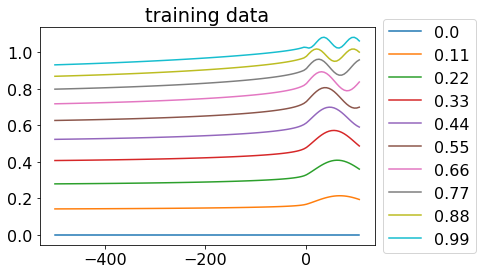

In [158]:
plt.figure()
for i in range(n_samples):
    plt.plot(data['times'], data['beta'][i], label=f"{np.around(chi1_array[i],3)}")
# plt.xlim(-100, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("training data")

In [159]:
plt.figure()
for i in range(n_samples):
    plt.plot(data['times'], val_data['beta'][i], label=f"{np.around(chi1_val_array[i],3)}")
# plt.xlim(-100, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("validation data")

Text(0.5, 1.0, 'validation data')

# fits

## pre-procesing

In [160]:
from sklearn.pipeline import make_pipeline

In [161]:
times_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=[-1,0])

In [162]:
times = data['times'].reshape(-1,1)

In [163]:
times_scaled = times_scaler.fit_transform(times)

In [164]:
times_scaled.shape

(122, 1)

In [165]:
data_no_scale = {}
data_no_scale['X_train'] = chi1_array.copy().reshape(-1, 1)
data_no_scale['y_train'] = data["beta"].copy()

data_no_scale['X_val'] = chi1_val_array.copy().reshape(-1, 1)
data_no_scale['y_val'] = val_data["beta"].copy()

In [166]:
X_train = chi1_array.copy().reshape(-1, 1)
y_train = data["beta"].copy()

X_val = chi1_val_array.copy().reshape(-1, 1)
y_val = val_data["beta"].copy()

In [167]:
y_scaler = make_pipeline(sklearn.preprocessing.MinMaxScaler(), sklearn.preprocessing.Normalizer())
# y_scaler = make_pipeline(sklearn.preprocessing.Normalizer())
y_train = y_scaler.fit_transform(y_train)
y_val = y_scaler.transform(y_val)

In [168]:
X_train.shape

(10, 1)

In [169]:
y_train.shape

(10, 122)

In [170]:
X_val.shape

(10, 1)

In [171]:
y_val.shape

(10, 122)

In [172]:
plt.figure()
for i in range(X_train.shape[0]):
    plt.plot(times_scaled, y_train[i], label=f"{np.around(X_train[i],3)}")
# plt.xlim(-100, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("training data")

Text(0.5, 1.0, 'training data')

Text(0.5, 1.0, 'val data')

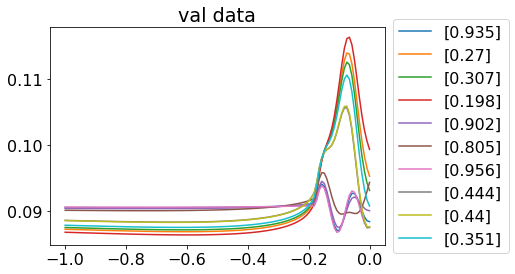

In [173]:
plt.figure()
for i in range(X_val.shape[0]):
    plt.plot(times_scaled, y_val[i], label=f"{np.around(X_val[i],3)}")
# plt.xlim(-100, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("val data")

In [174]:
def build_model(input_shape, output_shape, units, activation, n_hidden_layers):
    
    input_layer = tf.keras.Input(shape=(input_shape,))
    x = input_layer
    for i in range(n_hidden_layers):
        x = tf.keras.layers.Dense(units, activation=activation)(x)
        
#     dense_skip = tf.keras.layers.Dense(units, activation=activation)(input_layer)
#     x = tf.keras.layers.add([dense_skip, x])
    output_layer = tf.keras.layers.Dense(output_shape)(x)
    
    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [175]:
class Run(object):
    def __init__(self, name, params):
        self.name = name
        self.params = params
        
    def plot_history(self, history):
        plt.figure()
        plt.plot(history.history['loss'], label='loss 1', c='C0')
        plt.plot(history.history['val_loss'], label='val 1', c='C0', ls='--')

        plt.axhline(1e-05, c='k', ls='--')

        plt.yscale('log')
        plt.xscale('log')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    def plot_lr(self, history):
        plt.figure()
        plt.plot(history.history['lr'], label='lr', c='C0')


        plt.yscale('log')
        plt.xscale('log')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# run with no Normalizer

In [203]:
run0 = Run(
    name='run0',
    params=dict(
    input_shape=data_no_scale['X_train'].shape[1],
    output_shape=data_no_scale['y_train'].shape[1],
    units=256,
    activation='s2relu',
    n_hidden_layers=5
))

In [204]:
run0.name

'run0'

In [205]:
run0.params

{'input_shape': 1,
 'output_shape': 122,
 'units': 256,
 'activation': 's2relu',
 'n_hidden_layers': 5}

In [206]:
run0.model = build_model(**run0.params)

In [207]:
run0.model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_54 (Dense)             (None, 256)               512       
_________________________________________________________________
dense_55 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_56 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_57 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_58 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_59 (Dense)             (None, 122)               3135

In [208]:
run0.model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

In [209]:
%%time
callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.8, patience=1000, min_lr=1e-6),
    wispy.callbacks.ThresholdCallback(1e-9),
    tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
]
run0.history = run0.model.fit(data_no_scale['X_train'], data_no_scale['y_train'], epochs=1000, batch_size=64, validation_data=(data_no_scale['X_val'], data_no_scale['y_val']), verbose=False, callbacks=callbacks)

Training:   0%|           0/1000 ETA: ?s,  ?epochs/s

CPU times: user 37.1 s, sys: 2.83 s, total: 39.9 s
Wall time: 34.9 s


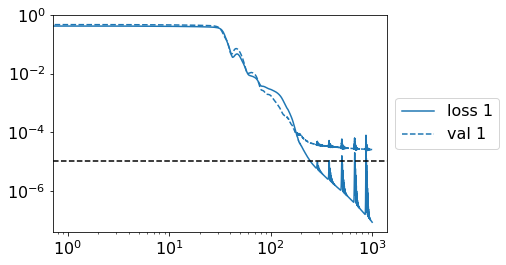

In [210]:
run0.plot_history(run0.history)

In [211]:
run0.model.predict(data_no_scale['X_train']).shape

(10, 122)

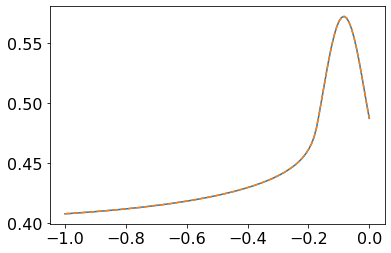

In [212]:
index=3
plt.figure()
plt.plot(times_scaled, data_no_scale['y_train'][index])
plt.plot(times_scaled, run0.model.predict(data_no_scale['X_train'])[index], ls='--')

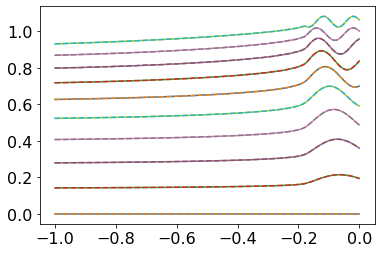

In [213]:
plt.figure()
for i in range(y_train.shape[0]):
    plt.plot(times_scaled, data_no_scale['y_train'][i])
    plt.plot(times_scaled, run0.model.predict(data_no_scale['X_train'])[i], ls='--')

In [214]:
plt.figure()
for i in range(y_train.shape[0]):
    plt.plot(times_scaled, data_no_scale['y_val'][i])
    plt.plot(times_scaled, run0.model.predict(data_no_scale['X_val'])[i], ls='--')

# run with Normalizer 

In [215]:
run1 = Run(
    name='run1',
    params=dict(
    input_shape=X_train.shape[1],
    output_shape=y_train.shape[1],
    units=256,
    activation='s2relu',
    n_hidden_layers=5
))

In [216]:
run1.name

'run1'

In [217]:
run1.params

{'input_shape': 1,
 'output_shape': 122,
 'units': 256,
 'activation': 's2relu',
 'n_hidden_layers': 5}

In [218]:
run1.model = build_model(**run1.params)

In [219]:
run1.model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_60 (Dense)             (None, 256)               512       
_________________________________________________________________
dense_61 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_62 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_63 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_64 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_65 (Dense)             (None, 122)               313

In [220]:
run1.model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

In [221]:
%%time
callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.8, patience=1000, min_lr=1e-6),
    wispy.callbacks.ThresholdCallback(1e-9),
    tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
]
run1.history = run1.model.fit(X_train, y_train, epochs=1000, batch_size=64, validation_data=(X_val, y_val), verbose=False, callbacks=callbacks)

Training:   0%|           0/1000 ETA: ?s,  ?epochs/s

CPU times: user 37.9 s, sys: 2.89 s, total: 40.8 s
Wall time: 35.7 s


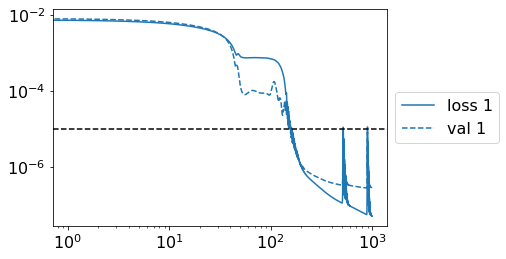

In [222]:
run1.plot_history(run1.history)

In [223]:
run1.model.predict(X_train).shape

(10, 122)

In [224]:
index=3
plt.figure()
plt.plot(times_scaled, y_train[index])
plt.plot(times_scaled, run1.model.predict(X_train)[index], ls='--')

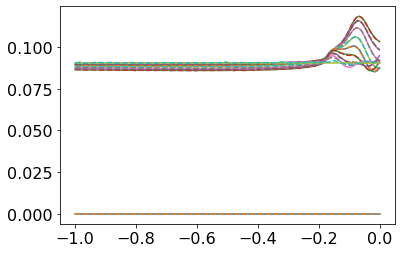

In [225]:
plt.figure()
for i in range(y_train.shape[0]):
    plt.plot(times_scaled, y_train[i])
    plt.plot(times_scaled, run1.model.predict(X_train)[i], ls='--')

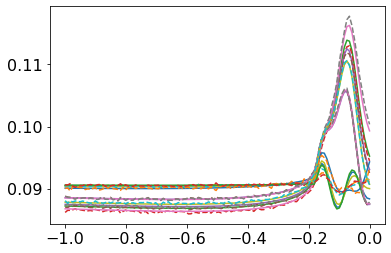

In [226]:
plt.figure()
for i in range(y_train.shape[0]):
    plt.plot(times_scaled, y_val[i])
    plt.plot(times_scaled, run1.model.predict(X_val)[i], ls='--')

# compare

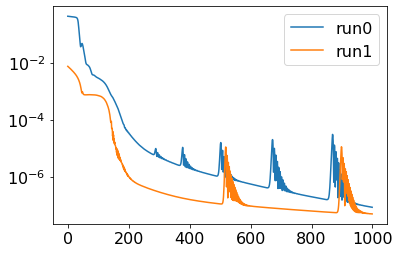

In [227]:
plt.figure()
plt.plot(run0.history.history['loss'], label=run0.name)
plt.plot(run1.history.history['loss'], label=run1.name)
plt.legend()
plt.yscale('log')

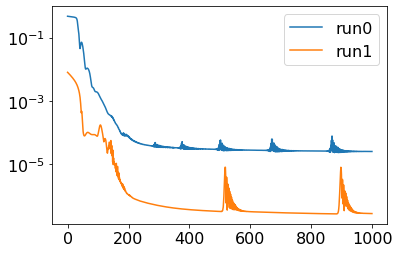

In [228]:
plt.figure()
plt.plot(run0.history.history['val_loss'], label=run0.name)
plt.plot(run1.history.history['val_loss'], label=run1.name)
plt.legend()
plt.yscale('log')

array([[ 0.11289754, -0.12992106,  0.03797965, -0.14112614,  0.03412358,
        -0.01333224, -0.0366675 , -0.02257598, -0.02614075, -0.03249009,
        -0.00940424,  0.09157456, -0.11895845, -0.00950782, -0.02936736,
         0.07404975,  0.04598242, -0.04358793,  0.04090645,  0.00928386,
         0.11834148, -0.03716749,  0.02755732, -0.05092635, -0.10989557,
         0.22885634, -0.09376657, -0.11365888,  0.07424477,  0.0331128 ,
         0.0787029 , -0.12174618,  0.00518407, -0.17450602,  0.01317619,
        -0.04529002, -0.18176594, -0.05807967,  0.15204777,  0.01149169,
         0.11592266,  0.01543388, -0.01486345,  0.08210457, -0.05456178,
        -0.0859483 , -0.0187834 , -0.03719062, -0.04394441,  0.07536411,
         0.1239251 ,  0.10986026,  0.02239759, -0.01035283, -0.04191957,
        -0.05631113, -0.003077  ,  0.08894602, -0.03657743, -0.01262875,
         0.06412504,  0.07216416,  0.07852725,  0.01534834, -0.05366175,
        -0.0305022 , -0.04347073,  0.04129018, -0.0

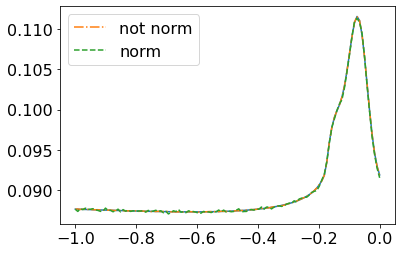

In [245]:
index=3
plt.figure()
plt.plot(times_scaled, y_train[index])


plt.plot(times_scaled, y_scaler.transform(run0.model.predict(data_no_scale['X_train'])[index].reshape(1,-1))[0], ls='-.', label='not norm')
plt.plot(times_scaled, run1.model.predict(X_train)[index], ls='--', label='norm')
plt.legend()

In [241]:
tf.keras.losses.mse(y_train[index], y_scaler.transform(run0.model.predict(data_no_scale['X_train'])[index].reshape(1,-1))[0])

<tf.Tensor: shape=(), dtype=float32, numpy=3.940157e-10>

In [242]:
tf.keras.losses.mse(y_train[index], run1.model.predict(X_train)[index])

<tf.Tensor: shape=(), dtype=float32, numpy=1.8250848e-08>

In [246]:
tf.keras.losses.mse(y_val[index], y_scaler.transform(run0.model.predict(data_no_scale['X_val'])[index].reshape(1,-1))[0])

<tf.Tensor: shape=(), dtype=float32, numpy=1.0212145e-07>

In [247]:
tf.keras.losses.mse(y_val[index], run1.model.predict(X_val)[index])

<tf.Tensor: shape=(), dtype=float32, numpy=5.922815e-07>